# Proximal policy optimization (PPO)

Mario Fiorino

$\;$

Gli algoritmi basati su tecniche di *Policy Gradient* sono un'area di ricerca molto attiva, con numerosi sviluppi negli ultimi anni. Tra questi Proximal Policy Optimization (PPO) risulta attualmente (anno 2025) tra i più usati per scopi applicativi. A riguardo OpenAI scrive:

*Proximal Policy Optimization (PPO), which perform comparably or better than state-of-the-art approaches while being much simpler to implement and tune. PPO has become the default reinforcement learning algorithm at OpenAI because of its ease of use and good performance.*
https://openai.com/index/openai-baselines-ppo/

$\;$

Avviso ai naviganti:

Per una comprensione dei concetti in questo notebook, si raccomanda ai lettori di prendere visione dei precedenti notebook dedicati alla tematica del Policy Gradient.
Può essere utile ricordare che i metodi definiti *Policy Gradient* sono algoritmi che utilizzano approssimatori parametrizzati, ovvero modelli matematici, per rappresentare le funzioni per la policy. I parametri di tali modelli vengono aggiornati iterativamente attraverso il metodo *Gradient ascent*, con l'obiettivo di massimizzare il *Return*.

#### Ref.

PPO: [J. Schulman et al., "Proximal Policy Optimization Algorithms." arXiv preprint arXiv:1707.06347, 2017.](https://arxiv.org/abs/1707.06347.pdf)

TRPO: [Schulman, John, et al. "Trust region policy optimization." International conference on machine learning. 2015.](http://proceedings.mlr.press/v37/schulman15.pdf)

Spinning Up - OpenAI :

https://spinningup.openai.com/en/latest/algorithms/trpo.html

https://spinningup.openai.com/en/latest/algorithms/ppo.html

Foundations of Reinforcement Learning: https://wensun.github.io/CS6789.html

Berkeley slide di Joshua Achiam:
https://rail.eecs.berkeley.edu/deeprlcourse-fa17/f17docs/lecture_13_advanced_pg.pdf

Foundations of Deep Reinforcement Learning: Theory and Practice in Python di Laura Graesser, Wah Loon Keng

### Alcune premesse

**Notazioni**
$\;$

$P \{X = x\}$ : probabilità che una variabile aleatoria $X$ assuma uno specifico valore (detto campione) $x$.  

$\;$

$X \sim p$: la variabile aleatoria $X$ è distribuita secondo la distribuzione di probabilità  $p$. In altre parole, un campione di $X$ viene estratto da una distribuzione con funzione di probabilità $p$.

$\;$

$\mathbb{E}[X]$: valore atteso o expectation di una variabile aleatoria \(X\), cioè  $ \mathbb{E}[X] = \sum_x p(x)x $

In pratica l'expectation, non è altro che un numero che rappresenta la media dei possibili valori che una variabile aleatoria può assumere, ciascuno ponderato in base alla probabilità di uscita. Ad esempio il valore atteso di una sola estrazione tra 3 premi rispettivamente di $\{5, 20, 50 \}$ euro, con pari probabilità di uscita $(1/3)$, è di $ 25 $ euro. Se la probabilità di $5$ euro è $1/2$ e gli altri due di $1/4$ ; allora il valore atteso è:
$E(X) = (5 \times \frac{1}{2}) + (20 \times \frac{1}{4}) + (50 \times \frac{1}{4}) = 20$ euro

$\;$

$\arg\max_a f(a) ≡$ valore di $a$ per cui $f(a)$ raggiunge il suo massimo.

$\;$

$\pi (a | s)$ definisce la probabilità di selezionare il valore $a$, dato come noto $s$.
$\;$

**Markov State Distributions**

Una *Markov Chain*, o processo di Markov, è un modello che descrive una sequenza di possibili eventi, dove la probabilità di ogni evento dipende esclusivamente dallo stato del sistema all'istante precedente.

Le *Markov State Distributions* descrivono la probabilità di trovare il sistema in un determinato stato in un dato momento.

Consideriamo un processo di Markov; una sequenza di $n$ variabili aleatorie $ [ X_0, X_1, ... , X_n ] $ , dove lo spazio degli esiti per ogni  $X_i$ è definito come $S = \{1, 2, 3, \dots,r\} $

Supponiamo di conoscere la distribuzione di probabilità iniziale $X_0$. Più precisamente, definiamo il vettore riga $d_{X_0}$ come  

$d_{X_0} = [P(X_0=1), \quad P(X_0=2), \quad \dots \quad , P(X_0=r)] $

Come possiamo ricavare la distribuzione di probabilità di $X_1, X_2, \dots$? Possiamo utilizzare la legge della probabilità totale.

Più precisamente, per ogni campione $ j \in S$ :  

$P(X_1 = j) = \sum_{k=1}^{r} P(X_1 = j \mid X_0 = k) P(X_0 = k) = \sum_{k=1}^{r} T_{kj} P(X_0 = k)$

dove $T$ è la matrice di transizione degli stati o anche detta *transition probabilities*.

In formula sintetica si riduce al prodotto riga colonna tra vettore e matrice:

$d_{X_1} = d_{X_0} \; T$

Più in generale, ad un certo istante $n$, per ricavare il vettore

$d_{X_n} = [P(X_n=1), \quad P(X_n=2), \quad \dots \quad , P(X_n=r)] $

abbiamo:

$d_{X_n} = d_{X_0} \; T^{n} $

$\;$

Esempio

Consideriamo un sistema che può trovarsi in uno dei due possibili stati, $ S = \{0,1\} $. In particolare, supponiamo che la matrice di transizione sia data da  

$T = \begin{bmatrix} \frac{1}{2} & \frac{1}{2} \\ \frac{1}{3} & \frac{2}{3} \end{bmatrix}.$

Le righe indicizzano lo stato corrente, le colonne indicizzano gli stati futuri. Ad esempio, per $T_{[1,0]} = \frac{1}{3}$ stiamo dicendo che partiamo dallo stato $1$ per cambiare nello stato $0$, e che questa transizione ha probabilità $\frac{1}{3}$. Per $T_{[1,1]} = \frac{2}{3}$ stiamo dicendo che la probabilità di restare nello stato $1$ e pari a $\frac{2}{3}$.

Supponiamo inoltre che il sistema si trovi nello stato $0$ al tempo $n = 0$; come ricavare la probabilità che il sistema sia nello stato $1$ al tempo $n=3$ ?

Noi sappiamo che lo stato del sistema iniziale è $X_0 = 0$, quindi la distribuzione di probabilità iniziale $X_0$:

$ d_{X_0} = [P(X_0 = 0) , \quad P(X_0 = 1)] = [1 , \quad 0]$

Applicanso la formula:
  

$d_{X_3} = d_{X_0} \; T^3 = [1 \quad 0] \begin{bmatrix} \frac{1}{2} & \frac{1}{2} \\ \frac{1}{3} & \frac{2}{3} \end{bmatrix}^3 = \left[ \frac{29}{72} \quad \frac{43}{72} \right]$

Di conseguenza, la probabilità che il sistema si trovi nello stato $1$ al tempo $n=3$ è $\frac{43}{72}$. (Mentre nello stato $0$ è $\frac{29}{72}$)

Ref.

https://www.probabilitycourse.com/chapter11/11_2_3_probability_distributions.php

**Discounted future state distribution**

Introduciamo la definizione di *discounted future state distribution* (o *discounted state distribution*)  per una data policy $\pi$, cioè:

$∀s \in S$,

$d^{\pi}(s) = (1 - \gamma) \sum_{k=0}^{\infty}  \;
 \gamma^k \; P(s_k = s| \pi) \;$

Sia $S$ l'insieme di tutti gli stati campionabili del sistema.

Sia $\gamma \in (0,1)$ il fattore di discount, allora la serie geometrica $\sum_{k=0}^{\infty}  \gamma^k$ converge a $\frac{1}{(1 - \gamma)}$, e il fattore $(1 - \gamma)$ è da considerarsi un fattore di normalizzazione.

Sia $P(s_k = s| \pi)$ la probabilità di trovarsi (o ritrovarsi) in un certo stato $s$, al tempo $k$, seguendo una certa la policy $𝜋$.

In sostanza, la distribuzione $d^{\pi}(s)$ tiene conto del fatto che un certo stato $s$ possa essere visitato più volte in istanti di tempo differenti, seguendo una determinata policy $\pi$.
Con questa definizione, agli stati prossimi a quello di partenza, con $k=0$, viene dato un peso maggiore.

Questa definizione rientra nell'ambito del *discounted weighting of states* ; vedi il lavoro di tesi di dottorato di Bacon 2018: https://pierrelucbacon.com/bacon2018thesis.pdf

Note:

1.

Perchè introduciamo il fattore di discount $\gamma$ nella ditribuzione degli stati?  In un processo decisionale di Markov con orizzonte infinito, il numero di volte in cui uno stato può essere visitato puo crescere indefinitamente. Introducendo il fattore $\gamma$ ci assicuriamo che la somma totale rimanga finita, con un valore $\le 1$. Per tanto il fattore discount, può essere pensato come una forma di "terminazione del episodio su scenari ad orizzonte infinito".

Maggiori info: https://ai.stackexchange.com/questions/27172/why-do-we-discount-the-state-distribution

2.

Come ricaviamo una distribuzione del genere dato che è implicitamente definita dalle dinamiche ambientali e dalla policy. Semplicemente eseguendo un *roll-out* secondo la policy $\pi$ per un tempo sufficientemente lungo, si otterrà un campionamento degli stati dalla distribuzione  $d^{\pi}$.

$\;$

## Problema: come gestire efficacemente l’update dei parametri della policy ?

Ovvero, come trovare lo *step-size* di aggiornamento massimo possibile (utilizzando i dati disponibili) senza compromettere le prestazioni ?  

Nei metodi policy gradient, l' update dei parametri $θ$ che caratterizzano la policy segue l'equazione:

$∆θ = α∇_θ J(π_θ)$

Va evidenziato che lo spazio delle policy e lo spazio dei parametri non sempre presentano una corrispondenza biunivoca, nel senso che una stessa distanza tra parametri non implica una distanza equivalente tra le rispettive policy; in ternimi matematici si dice che il *mapping è non-isometrico*.

Mi spiego: si considerino due coppie di parametri, denotate con $(\theta_1, \theta_2)$ e $(\theta_2, \theta_3)$, e si assuma che esse presentino la medesima distanza (ad esempio una distanza euclidea) nello spazio dei parametri, ovvero $D_{\theta}(\theta_1, \theta_2) = D_{\theta}(\theta_2, \theta_3)$. Tuttavia, le policy corrispondenti, mappate rispettivamente come $(\pi_{\theta_1}, \pi_{\theta_2})$ e $(\pi_{\theta_2}, \pi_{\theta_3})$, potrebbero non rispettare la stessa relazione di distanza quando si considera le loro performance, misurata ad esempio attraverso il *Return* ottenuto.

In simboli:
$D_{\theta}(\theta_1, \theta_2) = D_{\theta}(\theta_2, \theta_3) \not\Leftrightarrow D_R(π_{θ_1}, π_{θ_2}) = D_R(π_{θ_2}, π_{θ_3})$

In altre parole, variazioni anche minime nei parametri possono indurre differenze significative nelle prestazioni della policy. Ciò implica che un aggiornamento non adeguatamente controllato può portare a un deterioramento della performance (*performance collapse*)

Definiamo una metrica, o volendo una distanza nello spazio delle policy, che valuti la differenza di performance tra due policy.

**Relative policy performance identity**:

$ J(\pi') - J(\pi) =  \mathbb{E}_{\tau \sim {\pi'}} \bigg[ \sum_{t=0} ^T \gamma^t \; A^{\pi}(s_t, a_t) \bigg]$

per ogni policy $π$, e $π'$.

Si osservi che questa metrica mette in relazione le prestazione di $π'$ con la funzione Advantage di $π$

Supponiamo ora di avere una policy $ \pi $, e che, a seguito di un aggiornamento dei parametri $ \theta $, la sua successiva iterazione sia rappresentata da $\pi'$. Con questa assunzione è possibile osservare alcune proprietà di interessanti. In tal caso infatti,La *relative policy performance identity*, $J(\pi') - J(\pi)$, funge da metrica per quantificare i miglioramenti apportati a una pocily. Un valore positivo di tale differenza indica che la nuova policy, $\pi'$, produce prestazioni migliori della policy precedente, $\pi$. Durante un processo di training, l'obiettivo ideale consiste nel selezionare una nuova politica, $\pi'$, che consente di massimizzare tale differenza ad ogni step di aggiornamento dei paramentri. Di conseguenza, massimizzare l'*objective function* $J(\pi')$ equivale a massimizzare questa identità, ovvero:

$\max\limits_{\pi'} \bigg( J(\pi') - J(\pi) \bigg) $


**Idea di fondo**

Impostare il problema della ricerca di una policy ottimale in modo tale da massimizza tale identità, implica che ogni iterazione della policy debba garantire un miglioramento non negativo (monotono), ovvero, $J(\pi) - J(\pi') \geq 0$; poiché, nel caso peggiore, si può semplicemente porre $\pi = \pi'$ (ed ottenere un miglioramento pari a $0$).  Questo consente di evitare crolli di performance durante l'addestramento (*performance collapse*).

Un limite di questa formulazione è la necessità di traiettorie campionate dalla nuova policy $ \pi'$ (vedi: Expectation : ${\tau \sim {\pi'}}$), le quali non sono disponibili prima dell'aggiornamento.

Che fare?

Si consideri:

- la *relative policy performance identity*:
 $J(\pi_0) - J(\pi) = \mathbb{E}_{\tau \sim {\pi'}} \bigg[ \sum_{t=0} ^∞ \gamma^t \; A^{\pi}(s_t, a_t) \bigg] $

- la distribuzione di probabilità degli stati per una data policy $\pi$;  ad esempio nelle premesse, abbiamo definito la  *discounted future state distribution* per una certa policy $\pi$, ed indicata con $d^{\pi}(\cdot)$


Sfruttando:

- la proprietà di linearità dell'expectation (cioè: $E[a_1 X_1 + a_2 X_2  + ... + a_n X_n ]=a_1 E[X_1]+ a_2 E[X_2] + ... +  a_n E[X_n]$); invece di esprimere l'expectation sull'intera traiettoria, possiamo riscrivere l'expectation come una somma su singoli step temporali

- per $\gamma \in (0,1)$ , la serie geometria è convergente $\sum_{t=0}^{\infty} \gamma^t = \frac{1}{1-\gamma}$,

possiamo scrivere:

$\mathbb{E}_{\tau \sim \pi'} \left[ \sum_{t=0}^{\infty} \gamma^t A^{\pi} (s_t, a_t) \right] = \frac{1}{1 - \gamma} \mathbb{E}_{s \sim d^{\pi'},{\;a \sim \pi'(\cdot | s)}}  \left[  A^{\pi}(s, a) \right] $

per maggior chiarezza, espandendo l'expectation:

$\mathbb{E}_{\tau \sim \pi'} \left[ \sum_{t=0}^{\infty} \gamma^t A^{\pi} (s_t, a_t) \right] =  \frac{1}{1 - \gamma} \sum_{s} d^{\pi'}(s) \sum_{a} \pi'(a | s) A^{\pi}(s, a) $

Esiste una limitazione che impedisce l'impiego di questa espressione come funzione obiettivo, cioè per ottmizzare i parametri della "nuova" policy $\pi'$. Per effettuare un aggiornamento, essa richiede che le traiettorie siano campionate dalla "nuova" politica da ricavare. Chiaramente, questa risulta non disponibile fino a dopo che l'aggiornamento sia stato completato...

Proviamo a risolvere la cosa usando le informazione disponibili, ovvero la "vecchia" policy $\pi$.

Riscriviamo l'identità relativa della performance, sfruttando il *weighted importance sampling* (in pratica: un metodo utilizzato per ricavare uno stimatore, nel nostro caso il valore atteso, di una distribuzione, generando campioni da una distribuzione diversa, ma nota), ovvero:

$ \frac{1}{1 - \gamma} \mathbb{E}_{s_t \sim d^{\pi'},{\;a_t \sim \pi'}}  \left[  A^{\pi}(s, a) \right] = \frac{1}{1 - \gamma} \mathbb{E}_{s \sim d^{\pi'},{\;a \sim \pi}}  \left[ \frac{\pi'(a|s)}{\pi(a|s)} A^{\pi}(s, a) \right] $

Questa formula pesa i valori della funzione Advance, generati utilizzando la distribuzione $\pi$,  mediante il rapporto delle probabilità di azione tra le due policy successive, $\pi$ e $\pi'$.  

L' unico problema rimane $s \sim d^{\pi'}$.

Se attuiamo una approssimazione del tipo $d^{\pi'} \approx d^{\pi}$, assmuniamo che policy successive $\pi$ e $\pi'$ siano relativamente vicine; si noti ciò può essere misurato usando la divergenza KL. Quanto devono essere vicine affinche la cosa funzioni è una bella domanda che vederemo dopo.
Al momento tale approssimazione ci permette di scrivere:

$ J(\pi') - J(\pi)  ≈ \frac{1}{1 - \gamma} \mathbb{E}_{s \sim d^{\pi},{\;a \sim \pi}}  \left[ \frac{\pi'(a|s)}{\pi(a|s)} A^{\pi}(s, a) \right] = \mathbb{E}_{\tau \sim \pi} \left[ \sum_{t=0}^{\infty} \gamma^t \frac{\pi'(a_t|s_t)}{\pi(a_t|s_t)} A^{\pi}(s_t, a_t) \right] $

e definire il **surrogate objective**, detto anche *surrogate advantage* :

$ J^{CPI} (\pi, \pi') = \mathbb{E}_{\tau \sim \pi} \left[ \sum_{t=0}^{\infty} \gamma^t \frac{\pi'(a_t|s_t)}{\pi(a_t|s_t)} A^{\pi}(s_t, a_t) \right]$

Dove CPI sta per *conservative policy iteration*.

Si noti, $J^{CPI} (\pi, \pi')$ è qualcosa su cui possiamo lavorare per ottmizzare i parametri $\theta$ della nuova policy $\pi'$; usando infomazioni campionate dalla "vecchia" policy $π$.

Si noti anche, a differenza dell'importance sampling classico, il "peso" usato, cioè : $ \frac{\pi'(a|s)}{\pi(a|s)}$, dipende solo dal time-step corrente, e non dall'intera storia precedente (in pratica non c'è una produttoria che accumula i vari time step - vedi importance sampling ratio). Questo permette di evitare che tale "peso" produca valori estremamente grandi o piccoli, complessi da gestire.

Appendice.

Al fine di una maggior chiarezza, espandendo expectation sulle traiettorie $\tau = (s_0, a_0, s_1, a_1, \dots)$, otteniamo:

$ J^{CPI} (\pi, \pi') = \sum_{\tau}  P(\tau | \pi) \sum_{t=0}^{\infty} \gamma^t \frac{\pi'(a_t | s_t)}{\pi(a_t | s_t)} A^{\pi}(s_t, a_t)  $

dove $P(\tau | \pi)$ è la probabilità che una certa traiettoria $\tau$ si campionata da $\pi$; che può essere ulteriorimente fattorizzata come: $P(\tau \mid \pi) = \rho_0 (s_0) \prod_{t=0}^{\infty} Pr(s_{t+1} \mid s_t, a_t) \pi(a_t \mid s_t)$

In cui $s_0$ viene campionato randomly dalla *start-state distribution*, indicata con $\rho_0$.

$\;$

Adesso, l'idea di base è usare il *surrogate objective* come funzione obiettivo al fine di ottimizzare i parametri attraverso l'algoritmo di gradient ascent, garantendo al contempo una gestione stabile dell'update (i.e. un miglioramento monotono delle prestazioni) durante la fase di training.

C'è una proprietà interessante di cui gode il *surrogate objective* e che supporta la nostra idea di base, ovvero che il suo gradiente, valutando l'espressione in $θ = θ_{old}$,  è uguale al gradiente della policy:

$\nabla_\theta J^{CPI} (\theta_{old},\theta) = \nabla_\theta J(\pi_\theta)$

Inoltre, il *surrogate objective* puo pensarsi come un'approssimazione lineare di $J(\pi') - J(\pi)$, poiché le loro derivate di primo ordine coincidono.

Torniamo un momento alla questione lasciata in sospeso, quanto devono essere vicine policy  $π$  e  $π′$ (o l'approssimazione  $d^{π'}≈d^π$) , affiche la *surrogate objective* sia un approssimazione accetabile.

Per avere una misura di questa vicinanza introduciamo il **relative policy performance bound**

$| ( J(\pi') - J(\pi) ) - J^{CPI} (\pi, \pi')  | \; \leq \;  C \; \; \sqrt{ \mathbb{E}_{s \sim d^\pi} \bigg[ D_{KL} (\pi'|| \pi )[s] \bigg] } $

Dove $D_{KL}(\pi' || \pi)[s]$: è la *Kullback-Leibler (KL) divergence* tra le policy $\pi'$ e $\pi$ nello state $s$. In formula:

$D_{KL}(\pi' || \pi)[s] = \sum_{a} \pi'(a|s) \log \frac{\pi'(a|s)}{\pi(a|s)}$

con sommatoria su tutte le possibili azioni $a$ in un certo stato $s$.

$C$ è una costante che deve essere opportunamente determinata

Riscirvendola in modo da esplicitare le sue caratteristiche:

$ J^{CPI} (\pi, \pi') - C \sqrt{\mathbb{E}_{s \sim d^\pi} \left[ D_{KL}(\pi' || \pi)[s] \right]} \leq J(\pi') - J(\pi)  \leq  J^{CPI} (\pi, \pi') + C \sqrt{\mathbb{E}_{s \sim d^\pi} \left[ D_{KL}(\pi' || \pi)[s] \right]} $

In pratica il *relative policy performance bound* afferma che la differenza di performance tra una nuova policy $\pi'$ e la vecchia policy $\pi$ è limitata (*bounded*) da un termine che dipende dalla divergenza KL tra le due policy.

A fine di accettare una modifica alla policy, la stima  $J^{CPI} (\pi, \pi')$  di $J(\pi') - J(\pi)$,  deve essere contenuta nell'errore: $C \sqrt{\mathbb{E}_{s \sim d^\pi} \left[ D_{KL}(\pi' || \pi)[s] \right]}$

Se inseriamo questi vincoli (*error bound*) nel nostro problema di ottimizzazione, possiamo garantire un miglioramento monotono della policy; in simboli:

$\underset{\pi'}{\operatorname{arg max}} \bigg( J^{CPI} (\pi, \pi') - C \sqrt{ \mathbb{E}_{s \sim d^\pi}  D_{KL}(\pi' || \pi)[s]} \bigg) \Rightarrow J(\pi') - J(\pi) \geq 0$

E' fondamentale notare è che un miglioramento monotono **non garantisce la convergenza a una politicy ottimale**

L'ottimizzazione della politica può comunque rimanere bloccata in un massimo locale in cui ogni iterazione della politica non produce alcun miglioramento, in pratica $J(\pi') - J(\pi) = 0$.

Garantire la convergenza rimane un problema aperto complesso.

Come formulare questa condizione di vincolo nella nostra procedura di ottimizzazione?

Una possibile strategia consiste nel limitare in modo diretto l'expectation della divergenza di KL:

$\mathbb{E}_{s \sim d^\pi} D_{KL}(\pi' || \pi)[s] \leq δ$

Il parametro $δ$ limita l'ampiezza della divergenza di KL, restringendo così la distanza con cui una nuova policy rispetto alla policy precedente. Questo intervallo è denominato **Trust Region**, e la disuguaglianza prima scritta è nota come **vincolo di trust region**.

Si osservi che $δ$  è un iperparametro che deve essere opportunamente regolato.

$\;$

**Concludendo**

$\theta_{k+1} = \arg \max_\limits{\theta} \; \mathbb{E}_{\tau \sim \pi_{\theta_{k}}} \left[ \sum_{t=0}^{\infty} \gamma^t \frac{\pi_{\theta}(a_t|s_t)}{\pi_{\theta_{k}}(a_t|s_t)} A^{\pi_{\theta_{k}}}(s_t, a_t) \right] $

${subject\;to\; the\; constraints \;:\;}  \mathbb{E}_{s \sim \pi_{\theta_k}} \bigg[{ D_{KL}\left(\pi_{\theta}(\cdot|s) || \pi_{\theta_k} (\cdot|s) \right)} \bigg] \leq δ$

La formula sopra è detta : **Trust Region Policy Optimization(TRPO) update**.

Lo scopo è trovare i valori di $θ$ che massimizzano la funzione obiettivo $J^{CPI} (\pi_{\theta_{k}},\pi_{\theta})$, ma considerando solo i valori di $θ$ che soddisfano la condizione di vincolo di trust region.

Finché le modifiche alla policy rimangono all'interno della trust region, è possibile evitare un deterioramento delle prestazioni (*performance collapse*)

Si noti:

1.

$\mathbb{E}_{s \sim \pi_{\theta_k}} \left[ D_{KL}\left(\pi_{\theta}(\cdot|s) || \pi_{\theta_k} (\cdot|s) \right) \right]$ rappresenta la divergenza KL media tra le politiche $\pi_{\theta}$ e $\pi_{\theta_k}$, ponderata sulla distribuzione degli stati visitati dalla vecchia policy $\pi_{\theta_k}$.

2.

L'idea fondamentale risiede nell'utilizzo di $J^{CPI} (\pi_{\theta_{k}},\pi_{\theta})$ come un'approssimazione di $J(\pi_{\theta}) - J(\pi_{\theta_{k}})$, campionando dati dalla policy disponibile $\pi_{\theta_k}$. L' introduzione di tale approssimazione comporta inevitabilmente l'insorgere di un errore. Tuttavia, è possibile definire un limite per tale errore: trasformando questo limite in un vincolo nell'ambito del problema di ottimizzazione.

## Proximal Policy Optimization, algoritmo

Diversi algoritmi sono stati proposti per risolvere il problema di ottimizzazione con vincoli di trust region. Tra questi:  *Natural Policy Gradient (NPG)* , il *Trust Region Policy Optimization (TRPO)*  e il *Constrained Policy Optimization (CPO)*, *Proximal Policy Optimization (PPO)*.

PPO rappresenta un approccio di facile implementazione, con un costo computazionale basso, e privo della necessità di selezionare il parametro $\delta$.

Per queste ragioni, non solo è divenuto uno degli algoritmi di riferimento per la risoluzione di problemi di ottimizzazione vincolata trust region, ma anche uno dei metodi più diffusi nell'ambito dei policy gradient

Esistono due principali varianti dell'algoritmo PPO:

1.

La variante **PPO-KL-Penalty** converte la *constraint* sulla KL-divergence: $\mathbb{E}_t [ D_{KL} (\pi_{\theta} (a_t | s_t) || \pi_{\theta_{\text{k}}} (a_t | s_t))] \leq \delta $, in una penalizzazione ( che scoraggia la nuova policy dallo discostarsi troppo da quella vecchia ${\pi_{\theta_{\text{k}}}}$) adattiva, che viene sottratta al *importance-weighted advantage*:

$ \arg \max_\limits{\theta} \; \mathbb{E}_t \left[ \frac{\pi_{\theta} (a_t | s_t)}{\pi_{\theta_{\text{k}}} (a_t | s_t)} A^{\pi_{\theta_{\text{k}}}} (a_t , s_t) - \beta \; D_{KL}\left(\pi_{\theta}(a_t | s_t) || \pi_{\theta_{\text{k}}} (a_t | s_t) \right) \right] $

dove $\beta$ è il coefficiente che controlla le dimensione della penalizzazione sulla KL-divergence. Il suo valore viene automaticamente calibrato nel corso dell'addestramento usando metodi euristici (*heuristic-based update rule*), non derivanti cioè da da principi teorico-matematici. Per maggiori info applicative vedi il paper: J. Schulman et al., "Proximal Policy Optimization Algorithms"

2.

La variante **PPO-Clip**, invece, non include alcun termine di KL-divergence nella funzione obiettivo, ma sostituisce il vincolo sulla KL-divergence con una tecnica detta di clipping:

$ \arg \max_\limits{\theta} \; \mathbb{E}_t \bigg[ \min\left( \frac{\pi_{\theta}(a|s)}{\pi_{\theta_k}(a|s)} A^{\pi_{\theta_k}}(s,a), \ \text{clip}\left(\frac{\pi_{\theta}(a|s)}{\pi_{\theta_k}(a|s)}, 1 - \epsilon, 1+\epsilon \right) A^{\pi_{\theta_k}}(s,a) \right)  \bigg] $

$\epsilon$ è un iperparametro che deve essere messo a punto, e può essere ridotto progressivamente durante l'addestramento.

Il primo termine all'interno dell'operatore $\min(\cdot)$ corrisponde semplicemente all' *surrogate objective* $J^{CPI}$ . Il secondo termine, $\text{clip} (...)$, vincola il valore di $J^{CPI}$ all'intervallo $[(1 - \epsilon) A^{\pi_{\theta_k}}(s,a), (1 + \epsilon) A^{\pi_{\theta_k}}(s,a)]$.  

In pratica, se il rapporto $\frac{\pi_{\theta}(a|s)}{\pi_{\theta_k}(a|s)}$ assume valori al di fuori dell'intervallo $[1 - \epsilon, 1 + \epsilon]$, l'operatore di clipping $\text{clip}(\cdot)$ fornirà in uscita $(1 - \epsilon) A^{\pi_{\theta_k}}(s,a)$ nel caso di valori inferiori al limite inferiore $1 - \epsilon$, mentre restituirà $(1 + \epsilon) A^{\pi_{\theta_k}}(s,a)$ nel caso di valori superiori al limite superiore.

Quando $\frac{\pi_{\theta}(a|s)}{\pi_{\theta_k}(a|s)}$ appartiene all'intervallo $[1 - \epsilon, 1 + \epsilon]$, entrambi i termini all'interno dell'operatore $\min(\cdot)$ assumono lo stesso valore.

Con questa metodologia non vi è alcun incentivo a effettuare aggiornamenti di policy eccessivamente ampi.  

In genere, massimizzare l'obiettivo surrogato $J^{\text{CPI}}$ senza alcun vincolo potrebbe favorire aggiornamenti significativi nei parametri $𝜃$ della policy durante il processo di apprendimento. Ciò avviene poiché uno dei meccanismi attraverso cui è possibile massimizzare la funzione obiettivo consiste nell'apportare ampie variazioni a $\frac{\pi_{\theta}(a|s)}{\pi_{\theta_k}(a|s)}$. Per andare più a fondo nella questione suggerisco la lettura del *7.2 Proximal Policy Optimization (PPO)* - PDF 205, del testo *Foundations of Deep Reinforcement Learning: Theory and Practice in Python di Laura Graesser, Wah Loon Keng*

Infine, si osserva che i metodi PPO sono applicabili ad entrambi gli algoritmi di policy gradient studiati, REINFORCE e Actor-Critic. Appartiene alla classe degli algoritmi on-policy, e può essere applicato ad ambienti con spazi delle azioni sia discreti che continui.


# Coding : Actor-Critic PPO-clip  --> Solving Pendulum

## Moduli

In [1]:
import warnings
warnings.filterwarnings('ignore')

import sys

import matplotlib.pyplot as plt
import numpy as np
import random
from collections import deque
from typing import Deque, Dict, List, Tuple

import gym

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal

from IPython.display import clear_output

#Codice ispirato:
# https://github.com/MrSyee/pg-is-all-you-need/blob/master/02.PPO.ipynb

 [Codice](https://github.com/openai/gym/blob/master/gym/envs/classic_control/pendulum.py) di Pendulum-v1, dal  repository di OpenAI.

## Premesse tecniche

In [ ]:
# Come funziona il Clipping ?

epsilon = 3.7
epsilon = torch.tensor(epsilon)

for ratio in [-10, -3, 0, 4.65 ,4.75, 10]:
   ratio = torch.tensor(ratio)
   clipped_surr_loss = ( torch.clamp(ratio, 1.0 - epsilon, 1.0 + epsilon) )
   print(clipped_surr_loss)

tensor(-2.7000)
tensor(-2.7000)
tensor(0.)
tensor(4.6500)
tensor(4.7000)
tensor(4.7000)


In [ ]:
 # in GAE
 #  use of "deque / appendleft()"

returns = deque()
for i in range(1,5):
  returns.appendleft(i)

print(list(returns))

[4, 3, 2, 1]


In [ ]:
# mini-batch

buffer_size = 100
mini_batch_size = 7

imb = np.random.choice(buffer_size, mini_batch_size)
print(imb)
print("")

values = torch.randn(buffer_size)
print(values[imb])

[62  0 38 96  5 62  1]

tensor([ 1.8233, -1.0158,  0.4469,  1.1398,  0.1003,  1.8233, -0.2942])


## Network

Questo codice definisce due modelli di rete neurale separati, uno per l'Actor, altro per il Critic.

La rete Actor è responsabile della selezione del valore dell' azione dato in input uno stato. Esattamente produce in uscita la media (`mu`) e la deviazione standard logaritmica (`log_std`) della distribuzione (gaussiana) di probabilità dell'azione.

La rete Critic ricevuto lo stato in input, restituisce uno scalare che rappresenta il valore della *value fuction* dello stato.

Si ricordi:

L'ambiente Pendulum ha solo una singola azione con un intervallo compreso tra -2 e 2. Per garantire che l'azione rientri in tale intervallo, l'Actor restituisce un valore medio  ottenuto da una moltiplicazione per 2 di tanh. Si ricorda che tanh normalizza l'output tra -1 e 1.

Si noti infine che solo i pesi e i bias degli ultimi livelli vengono inizializzati con una distribuzione uniforme.



In [2]:
def init_layer_uniform(layer: nn.Linear, init_w: float = 3e-3) -> nn.Linear:
    """Init uniform parameters on the single layer."""
    layer.weight.data.uniform_(-init_w, init_w)
    layer.bias.data.uniform_(-init_w, init_w)

    return layer

class Actor(nn.Module):
    def __init__(
        self,
        in_dim: int,
        out_dim: int,
        log_std_min: int = -20,
        log_std_max: int = 0,
    ):
        """Initialize."""
        super(Actor, self).__init__()

        self.log_std_min = log_std_min
        self.log_std_max = log_std_max
        self.hidden = nn.Linear(in_dim, 32)

        self.mu_layer = nn.Linear(32, out_dim)
        self.mu_layer = init_layer_uniform(self.mu_layer)

        self.log_std_layer = nn.Linear(32, out_dim)
        self.log_std_layer = init_layer_uniform(self.log_std_layer)

    def forward(self, state: torch.Tensor) -> torch.Tensor:
        """Forward method implementation."""
        x = F.relu(self.hidden(state))

        #torch.tanh activation -> values ​​between -1 and 1
        mu = torch.tanh(self.mu_layer(x))* 2

        log_std = torch.tanh(self.log_std_layer(x))

        log_std = self.log_std_min + 0.5 * (self.log_std_max - self.log_std_min) * (log_std + 1)
        # Rescale this the value [-1,1] of log_std to the range [log_std_min, log_std_max]
        # why [-20, 0] ?
        # Since neural networks can output unbounded values, we constrain log_std to be within [-20, 0]
        # These values define the minimum and maximum possible standard deviation (std) for the action distribution.
        # std = e^−20 ≈ 2.06×10^−9 --> This ensures that std never becomes too small
        # std = e^0   = 1 --> This ensures that std never becomes too large. Note e^1.5 ≈ 4.5
        # Answer :   Ensures that std never becomes exactly zero and avoids excessive randomness.

        std = torch.exp(log_std)

        dist = Normal(mu, std)
        action = dist.sample()

        return action, dist


class Critic(nn.Module):
    def __init__(self, in_dim: int):
        """Initialize."""
        super(Critic, self).__init__()

        self.hidden = nn.Linear(in_dim, 64)
        self.out = nn.Linear(64, 1)
        self.out = init_layer_uniform(self.out)

    def forward(self, state: torch.Tensor) -> torch.Tensor:
        """Forward method implementation."""
        x = F.relu(self.hidden(state))
        value = self.out(x)

        return value

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## GAE

Per la stima della funzione Advantage, è usato il metodo del Generalized Advantage Estimation (GAE).

Questo approccio mira a ridurre la varianza dello stimatore, mantenendo al contempo il bias introdotto il più contenuto possibile.

Sia

$δ_t = r_t + γ  V^π (s_{t+1}) - V^π (s_{t})$

$A^{GAE, \; \pi} _t  = \sum _{l=0} ^∞ {(γ \; λ)^l \; δ_{t+l} }$

con $\lambda \in (0, 1)$ e  $\gamma \in [0, 1)$

Maggiori info: [Schulman J. et al (2015). High-dimensional continuous control using generalized advantage estimation.](https://arxiv.org/pdf/1506.02438)

Si ricordi che, per l'apprendimento della value function (output del Critic), l’approccio più semplice consiste nel risolvere un problema di regressione, trovando i valori dei parametri $\mathbf{w}$ che minizzano l'espressione :

$ \sum_{t=1}^T \left\| V^{\pi} _{target}(s_{t})  - \hat{V}^\pi(s_{t};\mathbf{w})  \right\|^2$

nello specifico:

GAE optimization:

 $V^{\pi} _{target} (s_t) ≈ A^{GAE \; \pi} _t (s_{t};\mathbf{w})  + \hat{V^\pi} (s_{t};\mathbf{w})$

In [3]:
def compute_gae(
    next_value: float,
    rewards: list,
    masks: list,
    values: list,
    gamma: float,
    tau: float
) -> List:
    """Compute gae."""
    values = values + [next_value]
    gae = 0
    returns: Deque[float] = deque()

    for step in reversed(range(len(rewards))):
        delta = (rewards[step] + gamma * values[step + 1] * masks[step] - values[step])
        gae = delta + gamma * tau * masks[step] * gae
        returns.appendleft(gae + values[step])
        # returns.appendleft(...) : returns list in the correct order while iterating in reverse
        # (gae + values[step]) : we need the target values for training the critic.

    return list(returns)

In [ ]:
# Test gae
next_value = 0.0
rewards = [1.0, 0.5, 1.0, 1.0, 0.02]
masks =   [1, 1, 1, 1, 1]
values =  [0.2, 1, 5, 1, 0.4]
gamma = 0.99
tau = 0.95

returns = compute_gae(next_value, rewards, masks, values, gamma, tau)
print(returns)


[3.5448788966588767, 2.6532470990525003, 2.026312705, 1.0386099999999998, 0.020000000000000018]


## PPO Agent
Summary PPOAgent class.

| Method           | Note                                                 |
|---               |---                                                   |
|select_action     | select an action from the input state.               |
|step              | take an action and return the response of the env.   |
|update_model      | update the model by gradient descent.                |
|train             | train the agent during num_frames.                   |
|evaluate_agent_performance              | test the agent.                          |
|_plot             | plot the training progresses.                        |


#### Mini-batch generator

L' algoritmo aggiorna il modello più volte (esattamente `epoch`volte), utilizzando strutture di memoria basate su liste (`List[torch.Tensor]`), la cui dimensione è determinata dal parametro `rollout_len`.

In pratica, per l'update,  la funzione `ppo_iter` estrae campioni (*mini-batch experience data*) da queste liste, fungendo da generatore di dati.





In [25]:
def ppo_iter(
    epoch: int,
    mini_batch_size: int,
    states: torch.Tensor,
    actions: torch.Tensor,
    values: torch.Tensor,
    log_probs: torch.Tensor,
    returns: torch.Tensor,
    advantages: torch.Tensor,
):
    """Yield mini-batches."""
    buffer_size = states.size(0) # = rollout_len
    for _ in range(epoch):
            rand_ids = np.random.choice(buffer_size, mini_batch_size)
            yield states[rand_ids, :], actions[rand_ids], values[rand_ids], log_probs[rand_ids], returns[rand_ids], advantages[rand_ids]

In [ ]:
#The dataset contains buffer_size samples.
# We divide it into smaller groups of mini_batch_size samples each.
#  The mini_batch produced, usally will be different from each other, due to:
#    rand_ids = np.random.choice(buffer_size, mini_batch_size)

# Define input
buffer_size = 6
state_dim = 4  # Assume states have 4 features
action_dim = 3  # Assume actions have 3 possible choices

# Create random tensors
states = torch.randn(buffer_size, state_dim)
actions = torch.randint(0, action_dim, (buffer_size,))
values = torch.randn(buffer_size)
log_probs = torch.randn(buffer_size)
returns = torch.randn(buffer_size)
advantages = torch.randn(buffer_size)
# Print the generated tensors
print("States:\n", states)
print("\nActions:\n", actions)
print("\nValues:\n", values)
print("\nLog Probs:\n", log_probs)
print("\nReturns:\n", returns)
print("\nAdvantages:\n", advantages)
print("\n")

# Hyperparameters
epochs = 2           # Number of times to loop over data
mini_batch_size = 3  # Number of elements in mini-batch

#print(ppo_iter(epochs, mini_batch_size, states, actions, values, log_probs, returns, advantages)) # <generator object ppo_iter at 0x7eda404b7df0>

# Testing
c = 0
for mini_batch in ppo_iter(epochs, mini_batch_size, states, actions, values, log_probs, returns, advantages):
    c+=1
    print("Mini-batch:", c)
    for data in mini_batch:
        print(data)
    print("-" * 40,"\n")


States:
 tensor([[ 1.0789,  0.2666, -0.6753,  0.3825],
        [ 0.9448, -0.0754,  0.6641, -0.1140],
        [ 0.0560,  0.7851,  1.9089,  0.1962],
        [-0.4523,  0.1661, -0.1562,  0.8245],
        [-1.5028, -0.7979, -0.0726, -0.7814],
        [ 0.1081,  0.0803, -0.3265, -0.1117]])

Actions:
 tensor([0, 2, 0, 2, 0, 2])

Values:
 tensor([-0.0441,  1.2948,  0.1950, -0.3552,  2.0536,  0.2982])

Log Probs:
 tensor([ 0.5328, -0.2248,  0.5454, -0.4114, -0.5961,  0.9094])

Returns:
 tensor([ 2.1009, -1.5110,  0.1362,  1.4254,  0.6449, -1.2025])

Advantages:
 tensor([-1.1808,  1.9435,  0.7037,  1.3710,  0.8751, -0.1698])


Mini-batch: 1
tensor([[ 0.1081,  0.0803, -0.3265, -0.1117],
        [ 0.0560,  0.7851,  1.9089,  0.1962],
        [ 0.9448, -0.0754,  0.6641, -0.1140]])
tensor([2, 0, 2])
tensor([0.2982, 0.1950, 1.2948])
tensor([ 0.9094,  0.5454, -0.2248])
tensor([-1.2025,  0.1362, -1.5110])
tensor([-0.1698,  0.7037,  1.9435])
---------------------------------------- 

Mini-batch: 2
tenso

### PPOAgent class

In [39]:
class PPOAgent:
    """PPO Agent.
    Attributes:
        env (gym.Env): Gym env for training
        gamma (float): discount factor
        tau (float): lambda of generalized advantage estimation (GAE)
        batch_size (int): Number of elements in mini-batch for update
        epsilon (float): amount of clipping surrogate objective
        epoch (int): the number of update
        rollout_len (int): the number of rollout
        entropy_weight (float): rate of weighting entropy into the loss function
        actor (nn.Module): target actor model to select actions
        critic (nn.Module): critic model to predict state values
        transition (list): temporory storage for the recent transition
        device (torch.device): cpu / gpu
        total_step (int): total step numbers
        is_test (bool): flag to show the current mode (train / test)
    """

    def __init__(
        self,
        env: gym.Env,
        batch_size: int,
        gamma: float,
        tau: float,
        epsilon: float,
        epoch: int,
        rollout_len: int,
        entropy_weight: float,  # Trailing commas makes it easy to add more arguments later, if necessary ...
    ):
        """Initialize."""
        self.env = env
        self.gamma = gamma
        self.tau = tau
        self.b_size = batch_size
        self.epsilon = epsilon
        self.epoch = epoch
        self.rollout_len = rollout_len
        self.entropy_weight = entropy_weight

        # device: cpu / gpu
        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu"
        )
        print(self.device)

        # setting the networks
        obs_dim = env.observation_space.shape[0]
        action_dim = env.action_space.shape[0]
        self.actor = Actor(obs_dim, action_dim).to(self.device)
        self.critic = Critic(obs_dim).to(self.device)

        # optimizer
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=0.001)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=0.005)

        # set memory for the training -> see: ppo_iter generator
        self.states: List[torch.Tensor] = []
        self.actions: List[torch.Tensor] = []
        self.rewards: List[torch.Tensor] = []
        self.values: List[torch.Tensor] = []
        self.masks: List[torch.Tensor] = []
        self.log_probs: List[torch.Tensor] = []

        # total steps count
        self.total_step = 0

        # mode: train / test
        self.is_test = False

    def select_action(self, state: np.ndarray) -> np.ndarray:
        """Select an action from the input state."""
        state = torch.FloatTensor(state).to(self.device)
        action, dist = self.actor(state)
        selected_action = dist.mean if self.is_test else action

        if not self.is_test:
            value = self.critic(state)
            self.states.append(state)                # All these ".append()"" will serve as dataset for mini-batch experience data
            self.actions.append(selected_action)
            self.values.append(value)
            self.log_probs.append(dist.log_prob(selected_action))

        # "selected_action.cpu().detach().numpy()[0]" somthieng like that : [0.02601556]
        return selected_action.cpu().detach().numpy()[0]

    def step(self, action: np.ndarray) -> Tuple[np.ndarray, np.float64, bool]:
        """Take an action and return the response of the env."""

        if self.is_test:
            next_state, reward, done, _ = self.env.step(action.reshape(1))
            return next_state, reward, done

        next_state, reward, done, _ = self.env.step(action)
        next_state = np.reshape(next_state, (1, -1)).astype(np.float64)
        reward = np.reshape(reward, (1, -1)).astype(np.float64)
        done = np.reshape(done, (1, -1))

        if not self.is_test:
            self.rewards.append(torch.FloatTensor(reward).to(self.device))
            self.masks.append(torch.FloatTensor(1 - done).to(self.device))

        return next_state, reward, done

    def update_model(self, next_state: np.ndarray) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """Update the model by gradient descent."""
        device = self.device  # for shortening the following lines

        next_state = torch.FloatTensor(next_state).to(device)
        next_value = self.critic(next_state)

        returns = compute_gae(
            next_value,
            self.rewards,
            self.masks,
            self.values,
            self.gamma,
            self.tau,
        )

        # Processing memory for training
        states = torch.cat(self.states).view(-1, 3)
        actions = torch.cat(self.actions)
        returns = torch.cat(returns).detach()
        values = torch.cat(self.values).detach()
        log_probs = torch.cat(self.log_probs).detach()
        advantages = returns - values

        actor_losses, critic_losses = [], []

        for state, action, old_value, old_log_prob, return_, adv in ppo_iter(
            epoch=self.epoch,
            mini_batch_size=self.b_size,
            states=states,
            actions=actions,
            values=values,
            log_probs=log_probs,
            returns=returns,
            advantages=advantages, # Trailing commas in function calls does not affect execution and ignored by the interpreter.
        ):
            # calculate ratios
            _, dist = self.actor(state)
            #Note
            # state torch.Size([64, 3])
            # dist torch.Size([64, 1])
            # action torch.Size([64, 1])
            # old_log_prob torch.Size([64, 1])
            log_prob = dist.log_prob(action)
            ratio = (log_prob - old_log_prob).exp() # Quotient of powers property: a^m / a^n = a^(m-n)
            # Note: (log_prob).exp() is a way to convert back from log probabilities to regular probabilities

            # actor_loss
            surr_loss = ratio * adv
            #Clipping
            clipped_surr_loss = (torch.clamp(ratio, 1.0 - self.epsilon, 1.0 + self.epsilon) * adv)

            # Entropy regularization
            entropy = dist.entropy().mean()

            actor_loss = ( -torch.min(surr_loss, clipped_surr_loss).mean() - entropy * self.entropy_weight)
            # "( -torch.min(surr_loss, clipped_surr_loss)" is somthing like this : torch.Size([64, 1])  ->  tensor([[17.0310],...[17.3662]])
            # "( -torch.min(surr_loss, clipped_surr_loss).mean()" :  tensor(13.0414)

            # critic_loss
            value = self.critic(state)
            #Alternative: clipped_value = old_value + (value - old_value).clamp(-0.5, 0.5)
            critic_loss = (return_ - value).pow(2).mean()
            # "(return_ - value).pow(2) " is somthing like this : torch.Size([64, 1])  ->  tensor([[1.4190], ..., [0.2553]])
            # "(return_ - value).pow(2).mean()"  :  tensor(1.1228)

            # train critic
            self.critic_optimizer.zero_grad()
            critic_loss.backward(retain_graph=True)
            self.critic_optimizer.step()

            # train actor
            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_optimizer.step()

            actor_losses.append(actor_loss.item())
            critic_losses.append(critic_loss.item())

        self.states, self.actions, self.rewards = [], [], []
        self.values, self.masks, self.log_probs = [], [], []

        actor_loss = sum(actor_losses) / len(actor_losses)
        critic_loss = sum(critic_losses) / len(critic_losses)

        return actor_loss, critic_loss

    def train(self, num_frames: int, plotting_interval: int = 5_000):
        """Train the agent."""
        self.is_test = False

        state = self.env.reset()
        state = np.expand_dims(state, axis=0)

        actor_losses, critic_losses = [], []   # for plotting
        scores = []                            # for plotting
        score = 0

        while self.total_step <= num_frames + 1:
            for _ in range(self.rollout_len):
                self.total_step += 1
                # The data that will then be used by the ppo_iter generator
                #  are stored thanks to the following two instructions
                action = self.select_action(state)
                next_state, reward, done = self.step(action)

                state = next_state
                score += reward[0][0]

                # if episode ends
                if done[0][0]:
                    state = env.reset()
                    state = np.expand_dims(state, axis=0)
                    scores.append(score)
                    score = 0

                # Plot
                if self.total_step % plotting_interval == 0:
                    self._plot(self.total_step, scores, actor_losses, critic_losses)
                    self.entropy_weight = self.entropy_weight * 0.5   # decay of entropy_weight


            #Update the model
            actor_loss, critic_loss = self.update_model(next_state)
            actor_losses.append(actor_loss)
            critic_losses.append(critic_loss)

        # termination
        self.env.close()

    def evaluate_agent_performance(self,num_episodes=1_000, baseline_reward=-150):

        #Baseline_reward:
        #https://github.com/openai/gym/wiki/Leaderboard

        better_scores_count = 0

        self.is_test = True
        state = self.env.reset(seed=99) # for the experimentation a "seed" different from the training

        # Run episodes
        for k in range(num_episodes):

          done = False
          score = 0

          while not done:
            action = self.select_action(state)
            next_state, reward, done = self.step(action)

            state = next_state
            score += reward

          state = env.reset()
          if score > baseline_reward:
             better_scores_count += 1

        # Compute the percentage
        success_percentage = (better_scores_count / num_episodes) * 100

        print("A better score than the", baseline_reward, " was taken in ", round(success_percentage,2), "% of times" )

        self.env.close()
        return None

    def _plot(
        self,
        frame_idx: int,
        scores: List[float],
        actor_losses: List[float],
        critic_losses: List[float],
    ):
        """Plot the training progresses."""

        def subplot(loc: int, title: str, values: List[float]):
            plt.subplot(loc)
            plt.title(title)
            plt.plot(values)

        subplot_params = [
            (131, f"frame {frame_idx}. score: {np.mean(scores[-10:])}", scores),
            (132, "actor_loss", actor_losses),
            (133, "critic_loss", critic_losses),
        ]

        clear_output(True)
        plt.figure(figsize=(30, 5))
        for loc, title, values in subplot_params:
            subplot(loc, title, values)
        plt.show()

## Initialize

In [49]:
# environment
env = gym.make("Pendulum-v1", render_mode="rgb_array")

# Set random seed
def seed_torch(seed):
    torch.manual_seed(seed)
    if torch.backends.cudnn.enabled:
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

seed = 777
random.seed(seed)
np.random.seed(seed)
seed_torch(seed)

# parameters
num_frames = 100_000

agent = PPOAgent(
    env,
    gamma = 0.9,
    tau = 0.8,
    batch_size = 64,          # Number of elements in mini-batch for update
    epsilon = 0.3,
    epoch = int((200*8)/2),   # Number of update per rollout-dataset
    rollout_len = 200*8,
    entropy_weight = 0.8      # this value will decay during the training
)

cuda


## Train

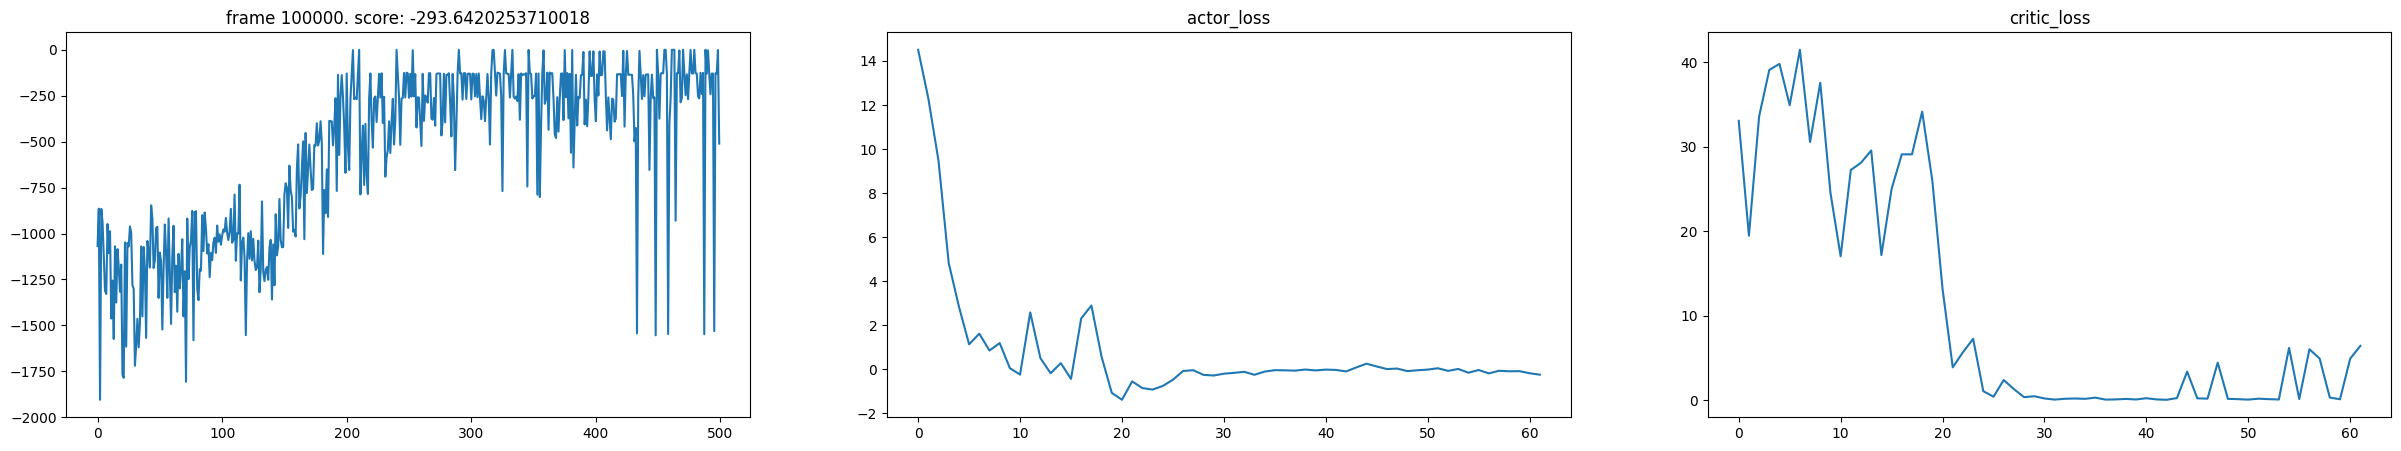

In [50]:
agent.train(num_frames)  # time : 13 minute

In [51]:
agent.entropy_weight

7.62939453125e-07

## Test

In [52]:
agent.evaluate_agent_performance(num_episodes=1_000,baseline_reward=-150)

A better score than the -150  was taken in  61.3 % of times
